<a href="https://colab.research.google.com/github/pransverse/ARK-selections/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from glob import glob

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pylab as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# FINDING FILTER

In [ ]:
pi_file = "/content/drive/MyDrive/pi_image.png"


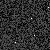

In [ ]:
pi_img = cv2.imread(pi_file,0)
cv2_imshow(pi_img)

In [ ]:
pi_arr = pi_img.flatten()

In [ ]:
pi_arr = pi_arr/10

In [ ]:
import mpmath
import math

In [ ]:
mpmath.mp.dps = 2500

In [ ]:
pi = 4* mpmath.atan(1)

In [ ]:
filter = []

In [ ]:
for i in range(2500):
  digit = int(pi)%10
  if (digit != pi_arr[i]):
    filter.append(digit)
  pi *= 10

In [ ]:
filter = np.array(filter)

In [ ]:
filter = filter*10*math.pi

In [ ]:
for i in range(4):
  filter[i] = int(math.floor(filter[i]))

In [ ]:
filter.sort()
filter = filter[::-1]

In [ ]:
filter = filter.reshape(2,2)

In [ ]:
print(filter)
filter = filter.astype('int16')

[[282. 251.]
 [ 94.   0.]]


Filter Found: [[282. 251.]
 [ 94.   0.]]

# RECOVERING PORTRAIT

In [ ]:
portrait = cv2.imread("/content/drive/MyDrive/artwork_picasso.png",0)
portrait = portrait.astype('int16')

In [ ]:
for i in range(0,99,2):
  for j in range(0,99,2):
    #applying the filter
    for x in range(2):
      for y in range(2):
        portrait[i+x][j+y] = int(portrait[i+x][j+y]) ^ int(filter[x][y])

In [ ]:
portrait = portrait%256

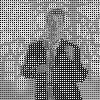

In [ ]:
cv2_imshow(portrait)

# TEMPLATE MATCHING

In [ ]:
collage = cv2.imread("/content/drive/MyDrive/collage.png",0)
collage = collage.astype('int16')

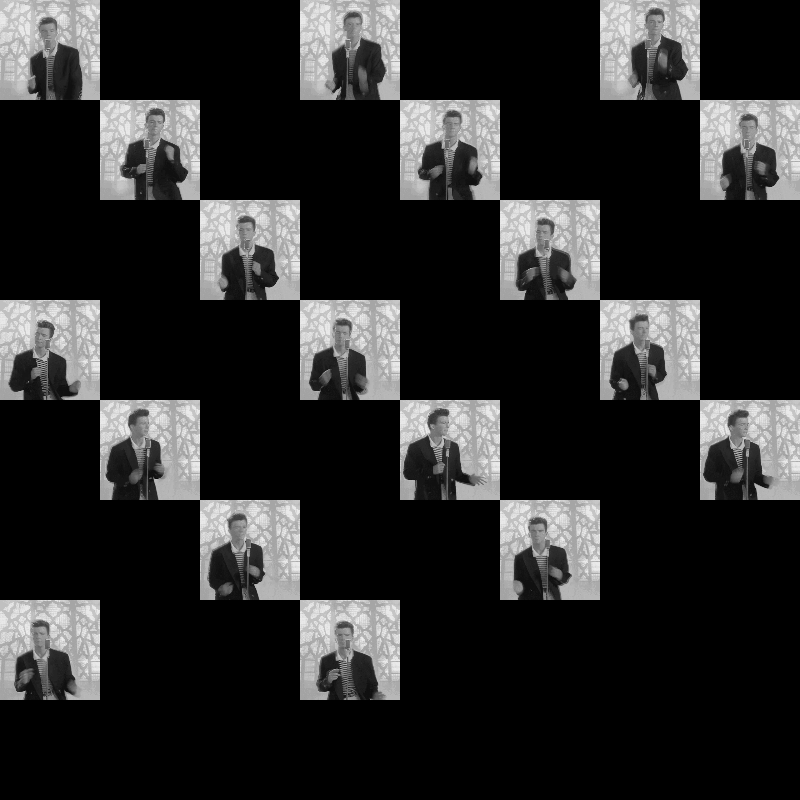

In [ ]:
cv2_imshow(collage)

In [ ]:
def ScoreCalculator(start_x, start_y):
  score = 0
  score += np.sum(abs(collage[start_x:start_x+100,start_y:start_y+100] - portrait))
  return score

In [ ]:
results = []
for i in range(701):
  for j in range(701):
    results.append(ScoreCalculator(i,j))

In [ ]:
#element with the minimum score is the one with the best match
matchindex = results.index(min(results))
match_x = int(matchindex/701)
match_y = int(matchindex%701)
print(match_x, match_y)

100 100


RESULT COMES OUT TO BE (100,100)

#MAZE

In [ ]:
maze = cv2.imread("/content/drive/MyDrive/maze.png",0)


40,330 - start easy

160, 20 - start hard

100, 330 - end easy

447,310 - end hard

GRID DIMENSIONS:
(8,20) - (447,330)

In [ ]:
import random
import math
import networkx as nx
import matplotlib.pyplot as plt


In [ ]:
class RRTconnect:
  def __init__(self, maze, start, end, max_iter = 5000, step_dist = 4, grid_min = (8,20), grid_max = (447,330)):

    self.start_tree = nx.Graph()
    self.start_tree.add_node(start)
    self.start = start

    self.end_tree = nx.Graph()
    self.end_tree.add_node(end)
    self.end = end

    self.max_iter = max_iter
    self.step_dist = step_dist
    self.grid_min = grid_min
    self.grid_max = grid_max

  def planner(self):
    for _ in range(self.max_iter):

      #generate a random point
      rand_point = self.generate_random_point()

      #extend start_tree towards random point and connect end_tree to the new point
      point, result = self.extend(self.start_tree, rand_point)
      if ((result) != 'Trapped'):
        if (self.connect(self.end_tree, point) == 'Reached'):
          path_start = nx.shortest_path(self.start_tree, self.start, point)
          path_end = nx.shortest_path(self.end_tree, self.end, point)
          path_end.reverse()
          path_start.extend(path_end)
          return path_start

      #generate a random point
      rand_point = self.generate_random_point()

      #extend tree2 towards random point and connect tree1 to the new point
      point, result = self.extend(self.end_tree, rand_point)
      if ((result) != 'Trapped'):
        if (self.connect(self.start_tree, point) == 'Reached'):
          path_start = nx.shortest_path(self.start_tree, self.start, point)
          path_end = nx.shortest_path(self.end_tree, self.end, point)
          path_end.reverse()
          path_start.extend(path_end)
          return path_start


    return None


  def generate_random_point(self):
    x = random.randint(self.grid_min[0],self.grid_max[0])
    y = random.randint(self.grid_min[1],self.grid_max[1])
    return (x,y)


  def euclidean_dist(self, q1, q2):
    dx = q1[0] - q2[0]
    dy = q1[1] - q2[1]
    return math.sqrt(dx**2 + dy**2)


  def nearest_neighbour(self, tree, target):
    nearest_dist = float('inf')
    nearest_vertex = None
    for vertex in tree.nodes:
      dist = self.euclidean_dist(vertex, target)
      if dist < nearest_dist:
        nearest_dist = dist
        nearest_vertex = vertex
    return nearest_vertex


  def extend(self, tree, target):
    if maze[target[1],target[0]] == 0:
      return None, 'Trapped'

    q_near = self.nearest_neighbour(tree, target)
    if self.euclidean_dist(q_near,target) <= self.step_dist:
      tree.add_node(target)
      tree.add_edge(q_near, target)
      return target, 'Reached'

    q_new = self.increment(q_near, target)

    if maze[q_new[1],q_new[0]] == 0:
      return None, 'Trapped'

    tree.add_node(q_new)
    tree.add_edge(q_near, q_new)
    return q_new, 'Advanced'

  def increment(self, q_near, target):
    dx = q_near[0] - target[0]
    dy = q_near[1] - target[1]
    angle = math.atan2(dy, dx) + math.pi
    q_new = int(q_near[0] + self.step_dist * math.cos(angle)), int(q_near[1] + self.step_dist * math.sin(angle))
    return q_new

  def connect(self, tree, target):
    point, result = self.extend(tree, target)

    while (result == 'Advanced'):
      if maze[target[1],target[0]] == 0:
        return 'Trapped'

      if self.euclidean_dist(point,target) <= self.step_dist:
        tree.add_node(target)
        tree.add_edge(point, target)
        return 'Reached'

      q_new = self.increment(point, target)

      if maze[q_new[1],q_new[0]] == 0:
        return 'Trapped'

      tree.add_node(q_new)
      tree.add_edge(point, q_new)
      point = q_new

    return result


[(40, 330), (42, 327), (43, 323), (46, 323), (49, 323), (52, 323), (55, 323), (58, 323), (61, 323), (64, 323), (64, 319), (66, 315), (65, 311), (67, 307), (66, 303), (65, 299), (66, 295), (66, 291), (66, 287), (65, 283), (63, 279), (65, 276), (67, 272), (66, 268), (67, 264), (67, 260), (66, 256), (64, 252), (66, 249), (64, 245), (67, 243), (66, 239), (66, 235), (62, 232), (61, 228), (60, 224), (63, 221), (66, 218), (66, 214), (63, 210), (63, 206), (66, 204), (65, 200), (67, 197), (67, 193), (65, 189), (63, 185), (66, 182), (66, 178), (67, 174), (64, 171), (63, 167), (66, 164), (66, 160), (67, 156), (67, 152), (65, 148), (63, 144), (61, 140), (58, 136), (57, 132), (55, 128), (53, 124), (56, 121), (55, 117), (58, 114), (60, 111), (63, 108), (62, 104), (64, 100), (62, 96), (60, 92), (56, 89), (56, 85), (58, 81), (55, 77), (57, 74), (60, 72), (63, 71), (66, 70), (69, 69), (72, 69), (75, 67), (75, 67), (74, 70), (74, 74), (74, 78), (74, 82), (74, 86), (74, 90), (74, 94), (74, 98), (74, 102)

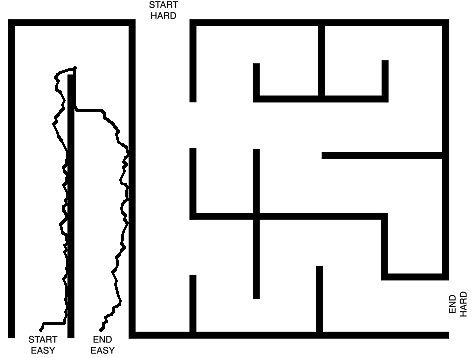

In [ ]:
rrt = RRTconnect(maze, (40,330), (100, 330))
path = rrt.planner()
print(path)
if path:
  n = len(path)
  for i in range(n-1):
    cv2.line(maze, path[i], path[i+1],3,2)
  cv2_imshow(maze)